# Çekişmeli Üretici Ağlar (Generative Adverserial Networks)

- Üretken modelleme, girdi verilerindeki kalıpları, orijinal veri kümesinden uygun bir şekilde çıkararak yeni örnekler oluşturabilmek için otomatik olarak keşfetmeyi ve öğrenmeyi içeren denetimsiz öğrenme türüdür.
- Klasik derin ağ mimarilerinden farklı olarak bir üretici (generative, G) ve bir ayırıcı (discriminator, D) olmak üzere iki farklı derin ağa sahiptir.
- Bu iki ağın çekişmeli olarak çalışmasıyla öğrenme işlemini gerçekleştirir.

![](bm-gan/3.png)

### Ayırıcı (Discriminator): 

- Bir evrişimsel sınıflandırıcıdır ve gelen görüntüleri sahte ya da gerçek olarak sınıflandırır.
- Gerçek ve sahte görüntü arasında ayrım yapmak için geleneksel CNN mimarisi kullanılır.

### Üretici (Generator):

- Üretici modeli biraz daha karmaşıktır.
- Üretici bunun tersini yapar 
- 100 boyutundaki vektörü bir görüntüye dönüştürür. 
- Bu özünde ters evrişim adı verilen bir süreci içerir. 
- Birlikte tensörün boyutunun her katmanda artmasına neden olurlar. 
- Ürettiği yeni görüntüler ile Discriminator sınıflandırıcıyı yanıltmak için çabalar.

### Uygulamalar

- Generating fake faces
- Face Aging
- Super Resolution
- Image-to-Image Translation
- Photos to Emojis
- Text to image Translation
- Generate Cartoon characters

## Örnek

In [1]:
import tensorflow as tf
import keras 
from keras import layers
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from tqdm import tqdm
import re
from keras.preprocessing.image import img_to_array

In [21]:
# to get the files in proper order
def sorted_alphanumeric(data):  
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)',key)]
    return sorted(data,key = alphanum_key)
# defining the size of the image
SIZE = 128
_img = []
path = 'IMG/'
files = os.listdir(path)
files = sorted_alphanumeric(files)
for i in tqdm(files):   
            img = cv2.imread(path + '/'+i,1)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (SIZE, SIZE))
            img = (img - 127.5) / 127.5 # Normalize the images to [-1, 1]
            imh = img.astype(float)
            _img.append(img_to_array(img))

  0%|                                     | 10/59998 [00:00<1:38:11, 10.18it/s]


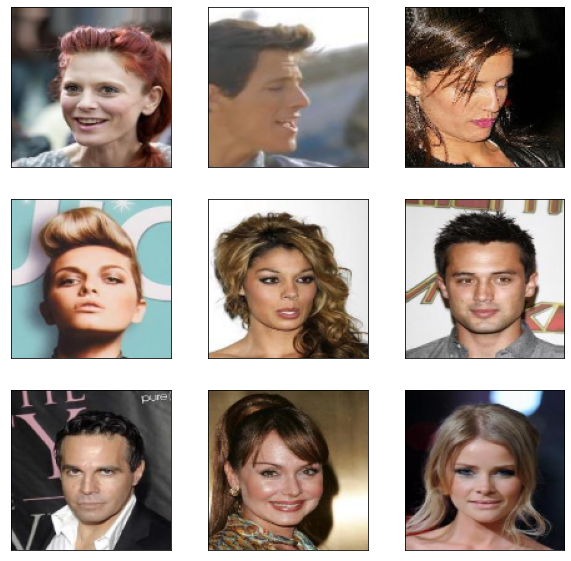

In [22]:
def plot_images(sqr = 5):
    plt.figure(figsize = (10,10))
    plt.title("Real Images",fontsize = 35)
    for i in range(sqr * sqr):
        plt.subplot(sqr,sqr,i+1)
        plt.imshow(_img[i]*0.5 + 0.5 )
        plt.xticks([])
        plt.yticks([])

# to plot images
plot_images(3)

In [24]:
batch_size = 32
dataset=tf.data.Dataset.from_tensor_slices(np.array(_img)).batch(batch_size)

In [10]:
latent_dim = 100
def Generator():
    model = tf.keras.Sequential()
    model.add(layers.Dense(128*128*3, use_bias=False, input_shape=(latent_dim,)))
    model.add(layers.Reshape((128,128,3)))
    # downsampling
    model.add(tf.keras.layers.Conv2D(128,4, strides=1, padding='same',kernel_initializer='he_normal', use_bias=False))
    model.add(tf.keras.layers.Conv2D(128,4, strides=2, padding='same',kernel_initializer='he_normal', use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Conv2D(256,4, strides=1, padding='same',kernel_initializer='he_normal', use_bias=False))
    model.add(tf.keras.layers.Conv2D(256,4, strides=2, padding='same',kernel_initializer='he_normal', use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Conv2DTranspose(512, 4, strides=1,padding='same',kernel_initializer='he_normal',use_bias=False))
    model.add(tf.keras.layers.Conv2D(512,4, strides=2, padding='same',kernel_initializer='he_normal', use_bias=False))
    
    model.add(tf.keras.layers.LeakyReLU())
    #upsampling
    model.add(tf.keras.layers.Conv2DTranspose(512, 4, strides=1,padding='same',kernel_initializer='he_normal',use_bias=False))
    model.add(tf.keras.layers.Conv2DTranspose(512, 4, strides=2,padding='same',kernel_initializer='he_normal',use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Conv2DTranspose(256, 4, strides=1,padding='same',kernel_initializer='he_normal',use_bias=False))
    model.add(tf.keras.layers.Conv2DTranspose(256, 4, strides=2,padding='same',kernel_initializer='he_normal',use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    
    model.add(tf.keras.layers.Conv2DTranspose(128, 4, strides=2,padding='same',kernel_initializer='he_normal',use_bias=False))
    model.add(tf.keras.layers.Conv2DTranspose(128, 4, strides=1,padding='same',kernel_initializer='he_normal',use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Conv2DTranspose(3,4,strides = 1, padding = 'same',activation = 'tanh'))
    return model

generator = Generator()
generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 49152)             4915200   
_________________________________________________________________
reshape (Reshape)            (None, 128, 128, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 128, 128, 128)     6144      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 128)       262144    
_________________________________________________________________
batch_normalization (BatchNo (None, 64, 64, 128)       512       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 64, 64, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 256)       5

- Girdi olarak normal dağılımdan rastgele vektör alır. 
- Bu rastgele vektör, Dense katmandan geçirilir ve yeniden şekillendirilir ve sonunda Convolution katmanlarından beslenir.
- Burada, evrişim katmanları, gizli vektörümüzün "downsampling" yapar.
- Bir dizi evrişim toplu normalleştirmesinden ve sızıntılı katmanı
- Downsampling gizli vektörümüz Conv2DTranspose kullanılarak upsampling yapılır.
- Generatorun son çıktı katmanı, (128,128,3). 
- Generatorun son katmanı, değeri -1 ile 1 arasına ezmek için aktivasyon olarak hiperbolik tanjantı kullanılır. 
- Generator modeli, giriş verilerinin önce altörneklendiği ve son olarak üstörneklendiği basit autoencoder modeline benzer.

In [11]:
def Discriminator():
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Input((SIZE, SIZE, 3)))
    model.add(tf.keras.layers.Conv2D(128,4, strides=2, padding='same',kernel_initializer='he_normal', use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Conv2D(128,4, strides=2, padding='same',kernel_initializer='he_normal', use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Conv2D(256,4, strides=2, padding='same',kernel_initializer='he_normal', use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Conv2D(256,4, strides=2, padding='same',kernel_initializer='he_normal', use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Conv2D(512,4, strides=2, padding='same',kernel_initializer='he_normal', use_bias=False))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(1,activation = 'sigmoid'))
    return model

discriminator = Discriminator()
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 64, 64, 128)       6144      
_________________________________________________________________
batch_normalization_5 (Batch (None, 64, 64, 128)       512       
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 64, 64, 128)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 32, 32, 128)       262144    
_________________________________________________________________
batch_normalization_6 (Batch (None, 32, 32, 128)       512       
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 16, 16, 256)      

- Diskriminatör modeli gerçek veya oluşturulabilen (128,128,3). 
- Bu girdi görüntüsü, Convolution katmanı kullanılarak downsampling ve sonunda flatten
- Gerçek ve sahte görüntüyü ayırt edebilmesi için tek nörona beslenir. 
- Son katman aktivasyon olarak sigmoid fonksiyonunu kullandığından 0 ile 1 arasında bir değer verir. 
- Burada 0,5'ten büyük olan değerler gerçek, 0,5'ten küçük olanlar ise sahte imajı ifade eder. 
- Generatorün eğitiminde diskriminatör çıktısı kullanılır.

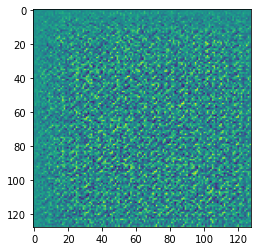

In [12]:
noise = np.random.normal(-1,1,(1,100))
img = generator(noise)
plt.imshow(img[0,:,:,0])
plt.show()

In [13]:
optimizer = tf.keras.optimizers.RMSprop(
        lr=.0001,
        clipvalue=1.0,
        decay=1e-8
    )
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits = True)

In [14]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output),fake_output)
def discriminator_loss(fake_output, real_output):
    fake_loss = cross_entropy(tf.zeros_like(fake_output),fake_output)
    real_loss = cross_entropy(tf.ones_like(real_output),real_output)
    return fake_loss + real_loss

In [15]:
def train_steps(images):
    noise = np.random.normal(0,1,(batch_size,latent_dim))
    with tf.GradientTape() as gen_tape , tf.GradientTape() as disc_tape:
        generated_images = generator(noise)
        fake_output = discriminator(generated_images)
        real_output = discriminator(images)
        
        gen_loss = generator_loss(fake_output)
        dis_loss = discriminator_loss(fake_output, real_output)
        
        
    gradient_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)    
    gradient_of_discriminator = disc_tape.gradient(dis_loss, discriminator.trainable_variables)
    
    optimizer.apply_gradients(zip(gradient_of_generator,generator.trainable_variables))
    optimizer.apply_gradients(zip(gradient_of_discriminator, discriminator.trainable_variables))
    
    loss = {'gen loss':gen_loss,
           'disc loss': dis_loss}
    return loss

In [16]:
def plot_generated_images(square = 5, epochs = 0):   
    
  plt.figure(figsize = (10,10))
  for i in range(square * square):
    if epochs != 0:    
        if(i == square //2):
            plt.title("Generated Image at Epoch:{}\n".format(epochs), fontsize = 32, color = 'black')
    plt.subplot(square, square, i+1)
    noise = np.random.normal(0,1,(1,latent_dim))
    img = generator(noise)
    plt.imshow(np.clip((img[0,...]+1)/2, 0, 1))
    
    plt.xticks([])
    plt.yticks([])
    plt.grid()

In [17]:
import time
def train(epochs,dataset):
    
    for epoch in range(epochs):
        start = time.time()
        print("\nEpoch : {}".format(epoch + 1))
        for images in dataset:
            loss = train_steps(images)
        print(" Time:{}".format(np.round(time.time() - start),2)) 
        print("Generator Loss: {} Discriminator Loss: {}".format(loss['gen loss'],loss['disc loss']))

In [18]:
train(5,dataset)


Epoch : 1
 Time:412.0
Generator Loss: 0.6148306131362915 Discriminator Loss: 2.072755813598633

Epoch : 2
 Time:385.0
Generator Loss: 1.188642272609286e-05 Discriminator Loss: 11.402835845947266

Epoch : 3
 Time:445.0
Generator Loss: 13.959619522094727 Discriminator Loss: 0.0017699466552585363

Epoch : 4
 Time:417.0
Generator Loss: 1.9803746938705444 Discriminator Loss: 0.15906715393066406

Epoch : 5
 Time:452.0
Generator Loss: 6.92505418555811e-05 Discriminator Loss: 9.664668083190918


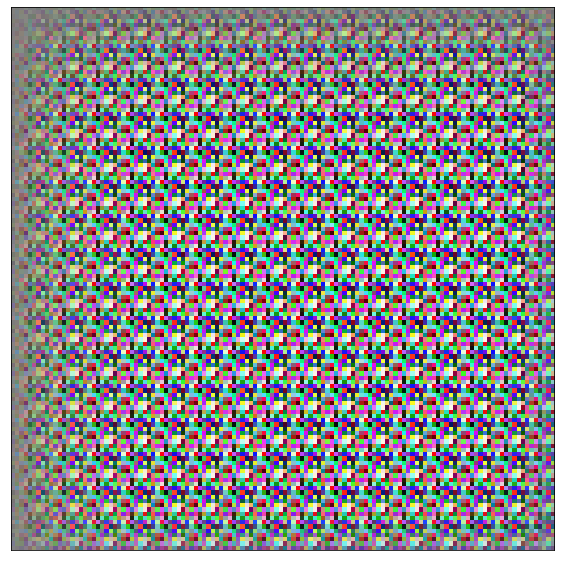

In [19]:
plot_generated_images(1)

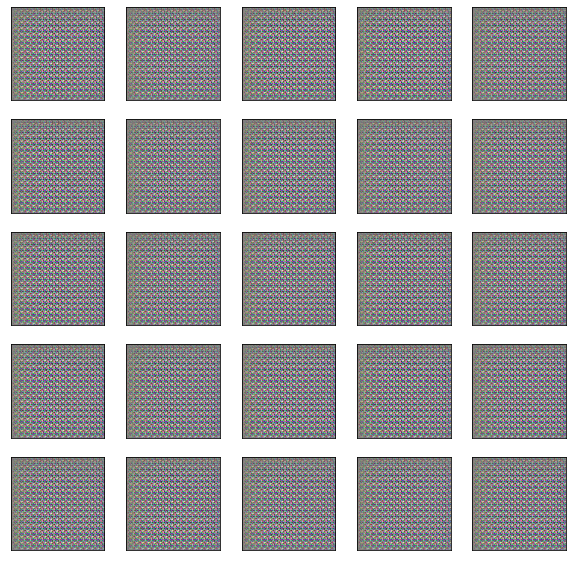

In [20]:
plot_generated_images(5)